# Unit 2 - Cost of Test

Group members:

- Ole Magnus Laerum
- Piotr Franc

# Task Description
Consider the dataset Breastcancer with the following partition train/test. Consider the test costs for each attribute given by the array testcosts (the first position of the array corresponds to the first attribute, CL.thickness, the second to Cell.size..). Consider also misclassification costs where the cost of predicting “benign” when the actual class is “malignant” is 20. The cost of predicting “malignant” when the actual class is “benign” is 4. Hits cost 0.

Try to minimise the global cost of your model. Draw a plot of test cost versus missclassification cost of the different options explored.

In [3]:
print("hello world")

[1] "hello world"


In [ ]:
install.packages("caret")
install.packages("mlbench")
install.packages("C50")

library(caret)

library(mlbench)
data(BreastCancer)
BreastCancer<-BreastCancer[,-1]
set.seed(480)
BreastCancer<-BreastCancer[complete.cases(BreastCancer),]
hv_index <- createDataPartition(BreastCancer$Class, p = .75, list = FALSE)
tr <- BreastCancer[ hv_index, ]
te <- BreastCancer[-hv_index, ]
testscosts<-c(2,4,3,1,5,3,2,4,2,0)



Installing package into 'C:/Users/franc/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'caret' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'caret'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\Users\franc\AppData\Local\R\win-library\4.4\00LOCK\caret\libs\x64\caret.dll to C:\Users\franc\AppData\Local\R\win-library\4.4\caret\libs\x64\caret.dll: Permission denied"
Warning message:
"restored 'caret'"



The downloaded binary packages are in
	C:\Users\franc\AppData\Local\Temp\RtmpGwYdbB\downloaded_packages


Installing package into 'C:/Users/franc/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'mlbench' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'mlbench'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\Users\franc\AppData\Local\R\win-library\4.4\00LOCK\mlbench\libs\x64\mlbench.dll to C:\Users\franc\AppData\Local\R\win-library\4.4\mlbench\libs\x64\mlbench.dll: Permission denied"
Warning message:
"restored 'mlbench'"



The downloaded binary packages are in
	C:\Users\franc\AppData\Local\Temp\RtmpGwYdbB\downloaded_packages


Installing package into 'C:/Users/franc/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'C50' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\franc\AppData\Local\Temp\RtmpGwYdbB\downloaded_packages


Loading required package: ggplot2

Loading required package: lattice



In [ ]:
set.seed(144)
index <- createDataPartition(BreastCancer$Class, p = 0.7, list = FALSE)
train = BreastCancer[ index,]
test  = BreastCancer[-index,]

model <- train(Class ~ ., data = train, method = "C5.0")

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.9932

Balanced Accuracy 
         1.963359 


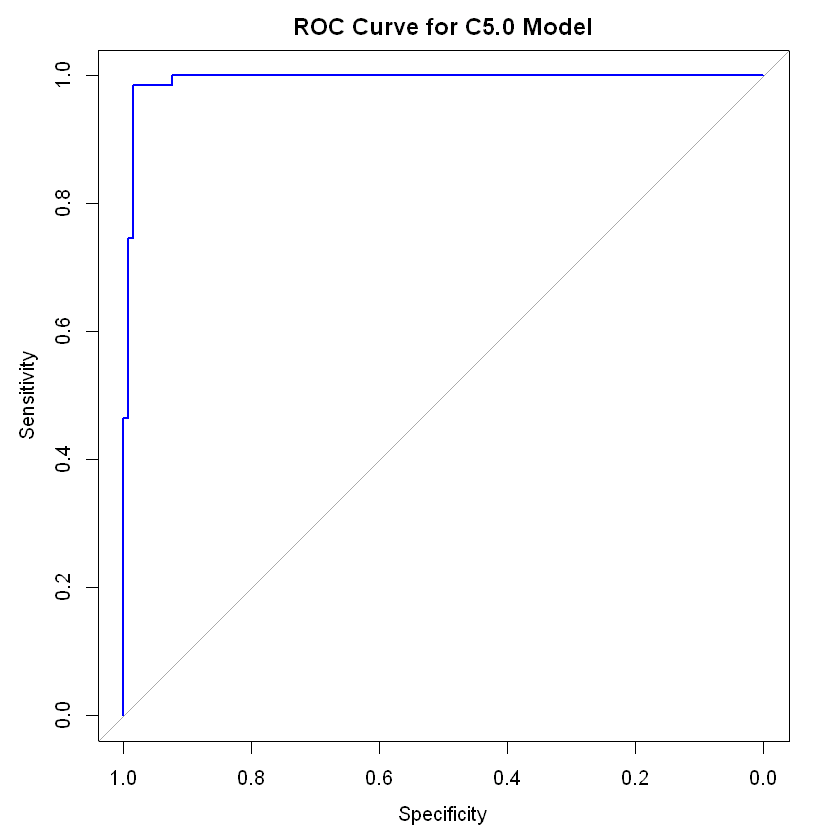

In [16]:
library(pROC)
library(caret)

# Get probability predictions
pred_probs <- predict(model, test, type = "prob")

# Convert actual class labels to binary (Malignant = 1, Benign = 0)
Class_numeric <- ifelse(test$Class == "malignant", 1, 0)

# Compute and plot ROC curve
roc_curve <- roc(Class_numeric, pred_probs[, "malignant"])
plot(roc_curve, col = "blue", main = "ROC Curve for C5.0 Model")
auc(roc_curve)

# Get class predictions
preds <- predict(model, test)

# Compute confusion matrix
cm <- confusionMatrix(preds, test$Class)

# Example cost calculation (adjust index based on testscosts length)
cost = cm$byClass["Balanced Accuracy"] * testscosts[1]
print(cost)
